In [1]:
import os
import yaml
import glob
import pickle
import numpy as np

from python_scripts.simulation import step_simulation
from python_scripts.visualizer import Visualizer
from commonroad.common.file_reader import CommonRoadFileReader

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [2]:
def merge_config(global_config, scenario_config):
    global_config["simulation_duration"]                    = scenario_config["simulation_duration"]
    global_config["initial_state_x"]                        = scenario_config["initial_state_x"]
    global_config["initial_state_y"]                        = scenario_config["initial_state_y"]
    global_config["initial_state_orientation"]              = scenario_config["initial_state_orientation"]
    global_config["initial_state_velocity"]                 = scenario_config["initial_state_velocity"]
    global_config["vehicle_type"]                           = scenario_config["vehicle_type"]
    global_config["vehicle_length"]                         = scenario_config["vehicle_length"]
    global_config["vehicle_width"]                          = scenario_config["vehicle_width"]
    global_config["reference_speed"]                        = scenario_config["reference_velocity"]
    global_config["planning_horizon"]                       = scenario_config["planning_horizon"]
    global_config["goal_point_x"]                           = scenario_config["goal_point_x"]
    global_config["goal_point_y"]                           = scenario_config["goal_point_y"]
    global_config["occlusion_params"]["vmax"]               = scenario_config["vmax"]
    global_config["occlusion_params"]["prediction_horizon"] = scenario_config["planning_horizon"]

    return global_config

def save_results(file_path, tracked_results, untracked_results, scenario, scenario_config, save_scenarios = False):
    if save_scenarios:
        tracked_scenarios = tracked_results[1]
        untracked_scenarios = untracked_results[1]
    else:
        tracked_scenarios = []
        untracked_scenarios = []
    data = {
        "simulation_length" : scenario_config["simulation_duration"],
        "scenario" :          scenario,
        "novel_method"      : {"ego_vehicle"        : tracked_results[0],
                               "scenarios"          : tracked_scenarios,
                               "views"              : tracked_results[2],
                               "shadows"            : tracked_results[3],
                               "emergency_brakes"   : tracked_results[4],
                               "computational_time" : {"update_step"    : tracked_results[5][0],
                                                       "prediction_step": tracked_results[5][1]}},
        "baseline_method"   : {"ego_vehicle"        : untracked_results[0],
                               "scenarios"          : untracked_scenarios,
                               "views"              : untracked_results[2],
                               "shadows"            : untracked_results[3],
                               "emergency_brakes"   : untracked_results[4],
                               "computational_time" : {"update_step"    : untracked_results[5][0],
                                                       "prediction_step": untracked_results[5][1]}},
        "vehicle_type"      : scenario_config["vehicle_type"], 
        "ego_speed"         : scenario_config["reference_velocity"],
        "other_speed"       : scenario_config["other_velocity"],
        "legal_merge"       : scenario_config["legal_merge"],
        "merge_ttc"         : scenario_config["merge_ttc"],
        "merge_dhw"         : scenario_config["merge_dhw"]
    }
    file = open(file_path, 'wb')
    pickle.dump(data, file)
    file.close()

def load_results(file_path):
    file = open(file_path, 'rb')
    data = pickle.load(file)
    file.close()
    
    return data

def plot_raw_scenario(timestep, scenario, config):
    plt.cla()
    Visualizer().plot_unsimulated(scenario, config, timestep)
    plt.axis('scaled')
    plt.xlim(0,420)
    plt.ylim(-45,-15)

def plot_result_scenario(time_step, ego_vehicle, scenarios, sensor_views):
    plt.cla()
    Visualizer().plot(scenario=scenarios[time_step],
                  sensor_view=sensor_views[time_step],
                  ego_vehicle=scenarios[time_step].obstacle_by_id(ego_vehicle.obstacle_id),
                  time_begin=time_step)
    plt.axis('scaled')
    plt.xlim(0,420)
    plt.ylim(-45,-15)

## Visualise scenario

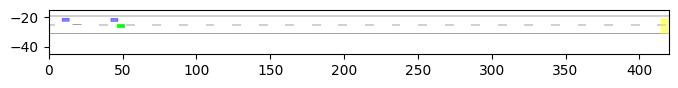

In [72]:
scenario_path = "scenarios/highd_scenarios/ZAM_HighD-1_1_T-1"

#======================================================#
with open("scenarios/highd_config.yaml") as file:
    global_config = yaml.load(file, Loader=yaml.FullLoader)
with open(scenario_path + ".yaml") as file:
    scenario_config = yaml.load(file, Loader=yaml.FullLoader)
config = merge_config(global_config, scenario_config)

scenario, _ = CommonRoadFileReader(scenario_path + ".xml").open()

fig = plt.figure(figsize=(12, 2))
anim = animation.FuncAnimation(fig, 
                               plot_raw_scenario, 
                               fargs=[scenario, config], 
                               frames=range(config["simulation_duration"]), 
                               interval=200, 
                               blit=False)
HTML(anim.to_html5_video())


## Run a single scenario

In [3]:
scenario_path = "scenarios/highd_scenarios/ZAM_HighD-1_1_T-1"
results_folder = "results/"

In [4]:
with open("scenarios/highd_config.yaml") as file:
    global_config = yaml.load(file, Loader=yaml.FullLoader)
with open(scenario_path + ".yaml") as file:
    scenario_config = yaml.load(file, Loader=yaml.FullLoader)
config = merge_config(global_config, scenario_config)

scenario1, _ = CommonRoadFileReader(scenario_path + ".xml").open()
scenario2, _ = CommonRoadFileReader(scenario_path + ".xml").open()

config['occlusion_params']['save_shadows'] = True

config['occlusion_params']['velocity_tracking_enabled'] = True
tracked_results = step_simulation(scenario1, config)

config['occlusion_params']['velocity_tracking_enabled'] = False
untracked_results = step_simulation(scenario2, config)

save_path = os.path.join(results_folder, str(scenario1.scenario_id))
save_results(save_path, tracked_results, untracked_results, scenario1, scenario_config, save_scenarios = True)

Running simulation: 100%|██████████| 46/46 [00:51<00:00,  1.13s/it]


## Visualise single result

In [5]:
results_file = "results/ZAM_HighD-1_1_T-1"

data = load_results(results_file)

#### Animation of novel method

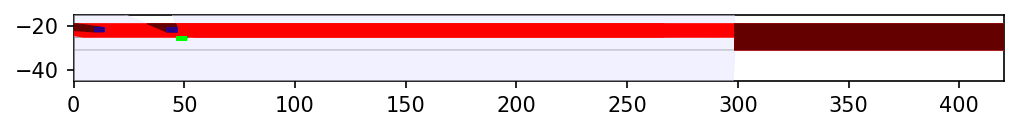

In [84]:
ego_vehicle = data["novel_method"]["ego_vehicle"]
scenarios = data["novel_method"]["scenarios"]
views = data["novel_method"]["views"]
simulation_length = data["simulation_length"]

fig = plt.figure(figsize=(12, 2), dpi=150)
anim = animation.FuncAnimation(fig, 
                               plot_result_scenario, 
                               fargs=[ego_vehicle, scenarios, views], 
                               frames=simulation_length, 
                               interval=200, 
                               blit=False)
HTML(anim.to_html5_video())

#### Animation of baseline method

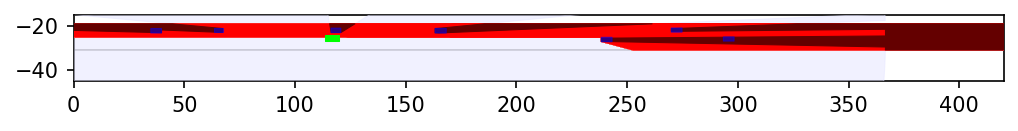

In [13]:
ego_vehicle = data["baseline_method"]["ego_vehicle"]
scenarios = data["baseline_method"]["scenarios"]
views = data["baseline_method"]["views"]
simulation_length = data["simulation_length"]

fig = plt.figure(figsize=(12, 2), dpi=150)
anim = animation.FuncAnimation(fig, 
                               plot_result_scenario, 
                               fargs=[ego_vehicle, scenarios, views], 
                               frames=simulation_length, 
                               interval=200, 
                               blit=False)
HTML(anim.to_html5_video())

#### Propagation of shadow volumes

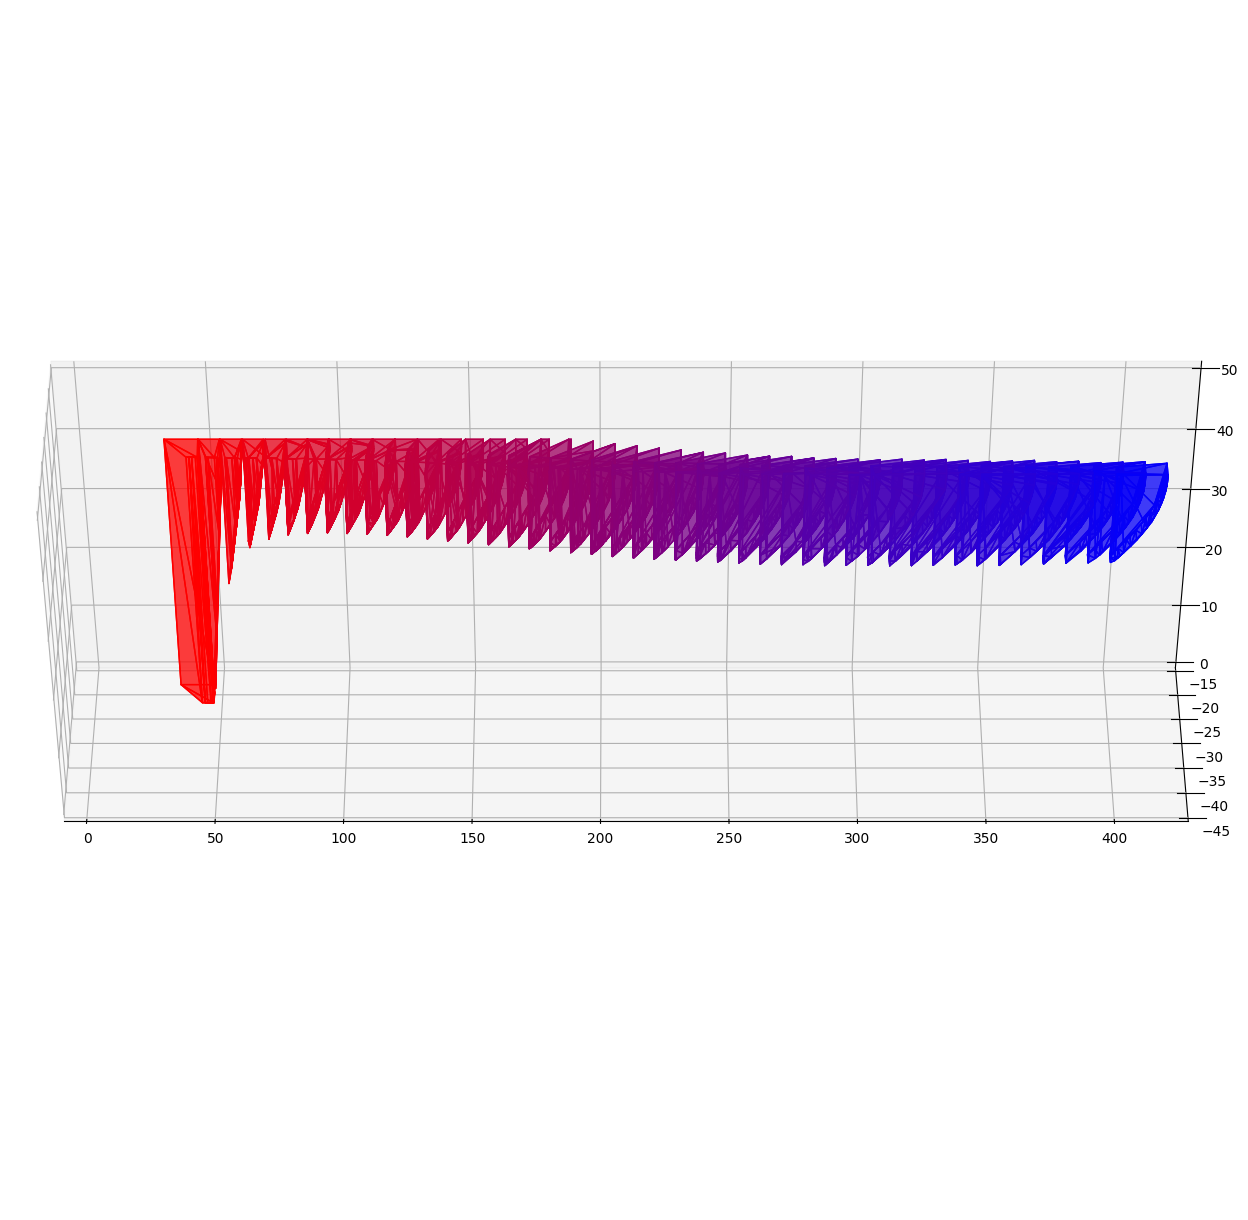

Update time novel method:  0.19916320645652172
Prediction time novel method:  0.6494476660434784
Update time baseline method:  0.07327589476086956
Prediction time baseline method:  1.0050035498478262


In [9]:
simulation_length = data["simulation_length"]
shadows_novel = data["novel_method"]["shadows"]
shadows_to_plot = [1]
if len(shadows_to_plot) == 0:
    shadows_to_plot = np.arange(len(shadows_novel))
for shadow in shadows_to_plot:
    Visualizer().plot_3D_shadows(shadows_novel[shadow],simulation_length,np.arange(0, simulation_length))

#### RSS distance comparisson

Text(0, 0.5, 'Distance Headway [m]')

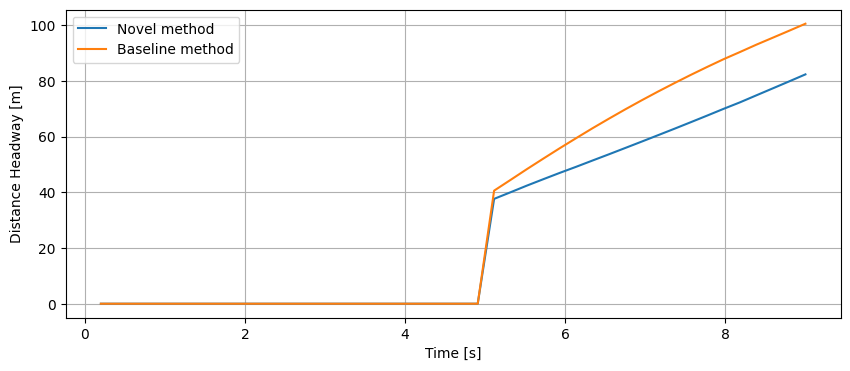

In [86]:
from python_scripts.utilities import find_RSS_distance

ego_novel = data["novel_method"]["ego_vehicle"]
ego_baseline = data["baseline_method"]["ego_vehicle"]
scenario = data["scenario"]
simulation_length = data["simulation_length"]

# Might need to rewrite RSS_distance function a bit
dists_novel = find_RSS_distance(ego_novel, scenario, config)
dists_baseline = find_RSS_distance(ego_baseline, scenario, config)
time = np.linspace(0.2, simulation_length/5, simulation_length-1) #assuming dt = 0.2

plt.figure(figsize=(10,4))
labels = ['Novel method','Baseline method']

plt.plot(time, dists_novel, label=labels[0])
plt.plot(time, dists_baseline, label=labels[1])
plt.legend()
plt.grid()

plt.xlabel('Time [s]')
plt.ylabel('Distance Headway [m]')

#### Velocity comparisson

(0.0, 9.0)

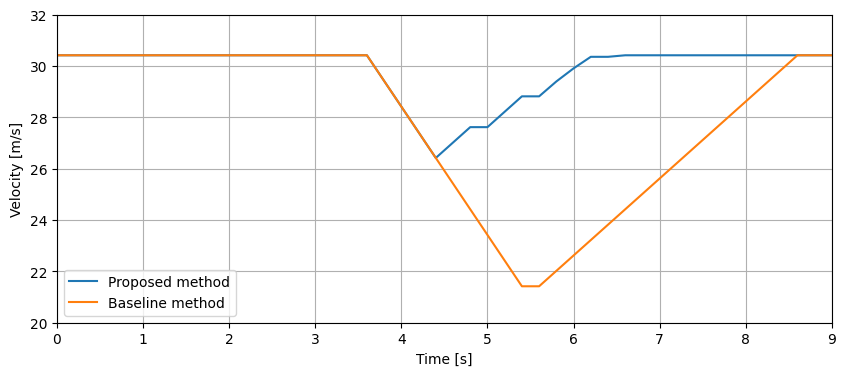

In [87]:
ego_novel = data["novel_method"]["ego_vehicle"]
ego_baseline = data["baseline_method"]["ego_vehicle"]

plt.figure(figsize=(10, 4))
labels = ['Proposed method','Baseline method']
for idx, vehicle in enumerate([ego_novel, ego_baseline]):
    velocities = [round(vehicle.initial_state.velocity, 2)]
    time = [round(vehicle.initial_state.time_step/10, 2)]
    for state in vehicle.prediction.trajectory.state_list:
        velocities.append(round(state.velocity, 2))
        time.append(round(state.time_step/5, 2))
    plt.plot(time, velocities, label=labels[idx])
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.grid()
plt.ylim(20, 32)
plt.xlim(0,9)

#### Computational times

In [10]:
print("Update time novel method: ", data["novel_method"]["computational_time"]["update_step"])
print("Prediction time novel method: ", data["novel_method"]["computational_time"]["prediction_step"])
print("Update time baseline method: ", data["baseline_method"]["computational_time"]["update_step"])
print("Prediction time baseline method: ", data["baseline_method"]["computational_time"]["prediction_step"])

Update time novel method:  0.19916320645652172
Prediction time novel method:  0.6494476660434784
Update time baseline method:  0.07327589476086956
Prediction time baseline method:  1.0050035498478262


## Run all scenarios

In [ ]:
skip_existing = True            # Skips any scenarios that already have existing results.
scenario_path = "scenarios/"
results_path = "results/highd_simulations_pickle"

In [6]:
path_xml = os.path.join(scenario_path, "*.xml")
path_yaml = os.path.join(scenario_path, "*.yaml")

xml_list = sorted(glob.glob(path_xml))
yaml_list = sorted(glob.glob(path_yaml))

with open("scenarios/highd_config.yaml") as file:
    global_config = yaml.load(file, Loader=yaml.FullLoader)

for xml_file, yaml_file in zip(xml_list, yaml_list):
    scenario1, _ = CommonRoadFileReader(xml_file).open()
    scenario2, _ = CommonRoadFileReader(xml_file).open()
    with open(yaml_file) as file:
        scenario_config = yaml.load(file, Loader=yaml.FullLoader)
    config = merge_config(global_config, scenario_config)

    if skip_existing and os.path.isfile(os.path.join(results_path, scenario1.scenario_id)):
        continue

    try:
        config['occlusion_params']['velocity_tracking_enabled'] = True
        tracked_results = step_simulation(scenario1, config)

        config['occlusion_params']['velocity_tracking_enabled'] = False
        untracked_results = step_simulation(scenario2, config)

    except Exception as e:
        print("Simulation raised an error for scenario ", scenario1.scenario_id)

    save_path = os.path.join(results_path, str(scenario1.scenario_id))
    save_results(save_path, tracked_results, untracked_results, scenario_config)

## Visualise all results

In [ ]:
results_folder = "results/highd_simulations_pickle"

#=========================#